**import libraries**

In [410]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
import re
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras.layers import Dense, Input, Embedding, LSTM, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Bidirectional, GlobalMaxPooling1D, Flatten

In [71]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [293]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [264]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### **Read Dataset**

In [2]:
!gdown --id 1XulBQYyiPRXMpwfm-RIvaDLCLDKIU6UD

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XulBQYyiPRXMpwfm-RIvaDLCLDKIU6UD
To: /content/review_10_product_women.csv
100% 9.48M/9.48M [00:00<00:00, 24.5MB/s]


In [17]:
df = pd.read_csv('/content/review_10_product_women.csv')

In [18]:
df.head()

,stars,title,body
0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...
1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...
2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...
3,5.0 out of 5 stars,OMG I love these pants.,They feel so good and smooth. Great if you are...
4,4.0 out of 5 stars,"Nice, but large","These are comfortable, but as others have ment..."


In [19]:
df.shape

(49802, 3)

### **Prepare** Dataset

In [20]:
df['star'] = df['stars'].apply(lambda x: str(x).split()[0]).astype(float)

In [21]:
df.head(3)

,stars,title,body,star
0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...,4.0
1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...,4.0
2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...,5.0


In [22]:
df['sentiment'] = df['star'].apply(lambda x: 1 if x >= 3 else 0)

In [23]:
df.head(3)

,stars,title,body,star,sentiment
0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...,4.0,1
1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...,4.0,1
2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...,5.0,1


In [24]:
df['sentiment'].unique()

array([1, 0])

In [25]:
df['sentiment'].value_counts()

1    45180
0     4622
Name: sentiment, dtype: int64

In [42]:
positive = df[(df['sentiment'] == 1)]
negative = df[(df['sentiment'] == 0)]

In [43]:
print(positive.shape)
print(negative.shape)

(45180, 5)
(4622, 5)


In [341]:
positive_sample = positive.sample(n=10_000, replace=True, random_state=50)

In [342]:
print(positive_sample.shape)
print(negative.shape)

(10000, 5)
(4622, 5)


In [343]:
data = pd.concat([positive_sample, negative], axis=0)

In [344]:
data.shape

(14622, 5)

In [345]:
data.tail()

,stars,title,body,star,sentiment
49795,1.0 out of 5 stars,Not good quality. Chinese low quality,Not flattering at all made me look huge and I ...,1.0,0
49796,2.0 out of 5 stars,Cute but too big,Way too big! And I got the smallest size. I’m ...,2.0,0
49797,2.0 out of 5 stars,Did not like high neck,No shape to the dress which was fine but not s...,2.0,0
49799,2.0 out of 5 stars,TOO SMALL,NOT TRUE TO FIT,2.0,0
49801,1.0 out of 5 stars,Feels cheap.,"Material feels thin, cheap and itchy. Definite...",1.0,0


### **Preprocessing**

In [346]:
bodies = data['body'].values
titles = data['title'].values
y = data['sentiment'].values

In [347]:
sentences = [(str(t)+' '+str(b)) for t,b in zip(titles,bodies)]

In [348]:
sentences[0]

'Great basics I have purchased a few pairs of these shorts, they look good, hold up, and are very affordable. They have apocket too so you can carry your phone or a mask easy! They are great basic shorts.'

In [349]:
tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenize = [tokenizer.tokenize(s.lower()) for s in sentences]

In [350]:
sentences_tokenize[5]

['great',
 'pair',
 'of',
 'pants',
 'very',
 'good',
 'fit',
 'and',
 'super',
 'comfortable',
 '1st',
 'pair',
 'of',
 'skinny',
 's',
 'i',
 'have',
 'tried',
 'and',
 'i',
 'really',
 'liked',
 'them']

In [351]:
stop_words = set(stopwords.words("english"))

In [352]:
len(stop_words)

179

In [353]:
sentences_tokenize_filtered = [[w for w in sentence if w not in stop_words] for sentence in sentences_tokenize]

In [354]:
sentences_tokenize_filtered[5]

['great',
 'pair',
 'pants',
 'good',
 'fit',
 'super',
 'comfortable',
 '1st',
 'pair',
 'skinny',
 'tried',
 'really',
 'liked']

In [355]:
lem = WordNetLemmatizer()
sentences_tokenize_filtered_stem = [[lem.lemmatize(w) for w in sentence] for sentence in sentences_tokenize_filtered]

In [356]:
sentences_tokenize_filtered_stem[5]

['great',
 'pair',
 'pant',
 'good',
 'fit',
 'super',
 'comfortable',
 '1st',
 'pair',
 'skinny',
 'tried',
 'really',
 'liked']

In [357]:
corpus = []
for sentence in sentences_tokenize_filtered:
  s = ''
  s = ' '.join(sentence)
  corpus.append(s) 

In [358]:
corpus[2:6]

['cutest kimono absolutely adorable paired leggings skinny jeans grey minimal flowers great detail received many compliments',
 'perfect light weight hoodie perfect light weight hoodie soft exactly looking size expected',
 'great shirt price love shirt super cute looks great jeans leggings dress pants skirt',
 'great pair pants good fit super comfortable 1st pair skinny tried really liked']

**keras Tokenizer**

In [359]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [360]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [361]:
vocab_size = len(tokenizer.word_index) + 1

In [362]:
vocab_size

9133

In [363]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [364]:
data_to_sequences = tokenizer.texts_to_sequences(corpus)

In [365]:
maxlen = max_length(data_to_sequences)
maxlen

326

In [366]:
data_to_sequences[5]

[6, 74, 44, 16, 1, 31, 7, 1137, 74, 202, 198, 35, 168]

In [367]:
pad_data_to_sequences = pad_sequences(data_to_sequences, maxlen=50)

In [368]:
pad_data_to_sequences[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    6,   74,   44,   16,    1,   31,    7,
       1137,   74,  202,  198,   35,  168], dtype=int32)

In [369]:
print(pad_data_to_sequences.shape)
print(y.shape)

(14622, 50)
(14622,)


In [370]:
X_train, X_test, y_train, y_test = train_test_split(pad_data_to_sequences, y, test_size=0.3, random_state=50)

In [371]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10235, 50)
(4387, 50)
(10235,)
(4387,)


## **Neural Networks**

### **CNN Model**

In [321]:
i = Input(shape=(50,))
x = Embedding(vocab_size, 50, input_length=50)(i)
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [322]:
model = Model(i, x)

In [323]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [324]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_12 (Embedding)    (None, 50, 50)            436700    
                                                                 
 conv1d_10 (Conv1D)          (None, 50, 32)            8032      
                                                                 
 dropout_27 (Dropout)        (None, 50, 32)            0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                           

In [325]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=7, batch_size=128)

Epoch 1/7
70/70 [==============================] - 3s 36ms/step - loss: 0.5849 - accuracy: 0.6772 - val_loss: 0.3879 - val_accuracy: 0.8437
Epoch 2/7
70/70 [==============================] - 2s 34ms/step - loss: 0.3122 - accuracy: 0.8706 - val_loss: 0.3204 - val_accuracy: 0.8630
Epoch 3/7
70/70 [==============================] - 2s 33ms/step - loss: 0.2304 - accuracy: 0.9133 - val_loss: 0.3256 - val_accuracy: 0.8672
Epoch 4/7
70/70 [==============================] - 2s 32ms/step - loss: 0.1870 - accuracy: 0.9354 - val_loss: 0.3550 - val_accuracy: 0.8550
Epoch 5/7
70/70 [==============================] - 2s 32ms/step - loss: 0.1582 - accuracy: 0.9445 - val_loss: 0.3783 - val_accuracy: 0.8608
Epoch 6/7
70/70 [==============================] - 2s 33ms/step - loss: 0.1352 - accuracy: 0.9553 - val_loss: 0.3938 - val_accuracy: 0.8569
Epoch 7/7
70/70 [==============================] - 2s 32ms/step - loss: 0.1085 - accuracy: 0.9636 - val_loss: 0.4718 - val_accuracy: 0.8540


In [326]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

119/119 [==============================] - 0s 3ms/step - loss: 0.4718 - accuracy: 0.8540
Accuracy: 85.40%


### **LSTM Model**

In [327]:
i = Input(shape=(50,))
x = Embedding(vocab_size, 50, input_length=50)(i)
x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [328]:
model = Model(i, x)

In [329]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [330]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_13 (Embedding)    (None, 50, 50)            436700    
                                                                 
 bidirectional_5 (Bidirectio  (None, 50, 256)          183296    
 nal)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 64)                82176     
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                           

In [331]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=7, batch_size=128)

Epoch 1/7
70/70 [==============================] - 43s 528ms/step - loss: 0.5039 - accuracy: 0.7444 - val_loss: 0.3687 - val_accuracy: 0.8268
Epoch 2/7
70/70 [==============================] - 36s 509ms/step - loss: 0.2900 - accuracy: 0.8801 - val_loss: 0.3333 - val_accuracy: 0.8569
Epoch 3/7
70/70 [==============================] - 35s 504ms/step - loss: 0.2281 - accuracy: 0.9116 - val_loss: 0.4100 - val_accuracy: 0.8603
Epoch 4/7
70/70 [==============================] - 35s 502ms/step - loss: 0.1967 - accuracy: 0.9237 - val_loss: 0.3849 - val_accuracy: 0.8495
Epoch 5/7
70/70 [==============================] - 36s 512ms/step - loss: 0.1616 - accuracy: 0.9418 - val_loss: 0.4387 - val_accuracy: 0.8548
Epoch 6/7
70/70 [==============================] - 36s 505ms/step - loss: 0.1447 - accuracy: 0.9488 - val_loss: 0.5141 - val_accuracy: 0.8482
Epoch 7/7
70/70 [==============================] - 35s 501ms/step - loss: 0.1484 - accuracy: 0.9483 - val_loss: 0.5022 - val_accuracy: 0.8424


In [332]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

119/119 [==============================] - 8s 63ms/step - loss: 0.5022 - accuracy: 0.8424
Accuracy: 84.24%


### **CNN-LSTM Model**

In [372]:
i = Input(shape=(50,))
x = Embedding(vocab_size, 50, input_length=50)(i)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [373]:
model = Model(i, x)

In [374]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [375]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_15 (Embedding)    (None, 50, 50)            456650    
                                                                 
 batch_normalization_6 (Batc  (None, 50, 50)           200       
 hNormalization)                                                 
                                                                 
 dropout_33 (Dropout)        (None, 50, 50)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 50, 32)            8032      
                                                                 
 dropout_34 (Dropout)        (None, 50, 32)            0         
                                                          

In [376]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=9, batch_size=128)

Epoch 1/9
80/80 [==============================] - 30s 298ms/step - loss: 0.4659 - accuracy: 0.7693 - val_loss: 0.6049 - val_accuracy: 0.8616
Epoch 2/9
80/80 [==============================] - 23s 291ms/step - loss: 0.2862 - accuracy: 0.8843 - val_loss: 0.5211 - val_accuracy: 0.8696
Epoch 3/9
80/80 [==============================] - 23s 283ms/step - loss: 0.2248 - accuracy: 0.9148 - val_loss: 0.4573 - val_accuracy: 0.8705
Epoch 4/9
80/80 [==============================] - 23s 283ms/step - loss: 0.1925 - accuracy: 0.9268 - val_loss: 0.3784 - val_accuracy: 0.8687
Epoch 5/9
80/80 [==============================] - 23s 283ms/step - loss: 0.1650 - accuracy: 0.9354 - val_loss: 0.3462 - val_accuracy: 0.8512
Epoch 6/9
80/80 [==============================] - 23s 282ms/step - loss: 0.1453 - accuracy: 0.9483 - val_loss: 0.3231 - val_accuracy: 0.8651
Epoch 7/9
80/80 [==============================] - 22s 278ms/step - loss: 0.1233 - accuracy: 0.9539 - val_loss: 0.3475 - val_accuracy: 0.8623
Epoch 

In [377]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

138/138 [==============================] - 5s 35ms/step - loss: 0.4564 - accuracy: 0.8632
Accuracy: 86.32%


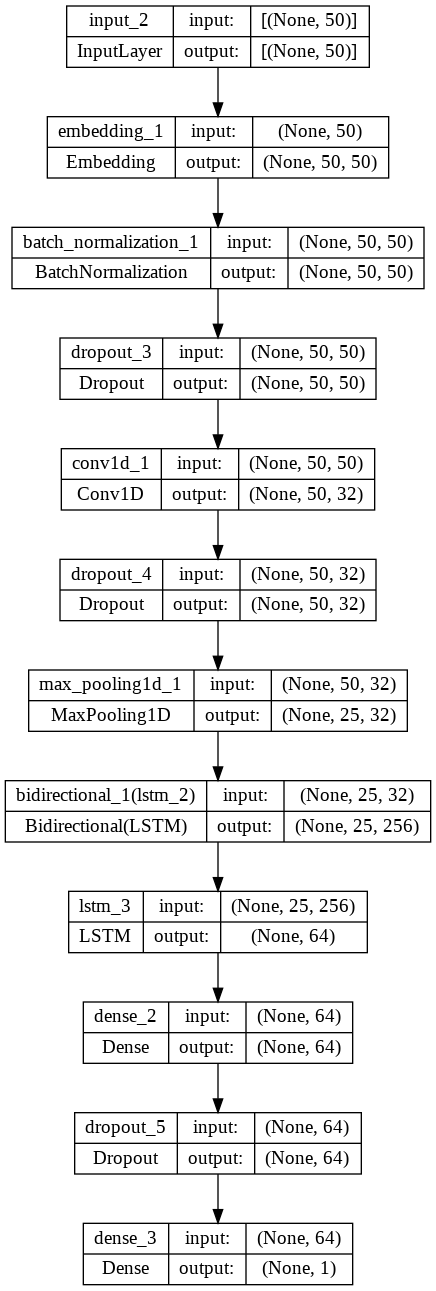

In [188]:
plot_model(model, show_shapes=True)

In [411]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

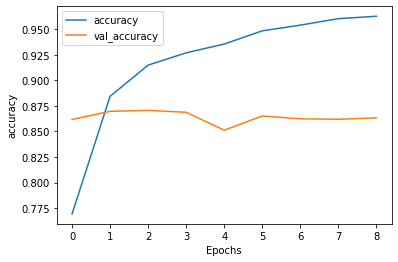

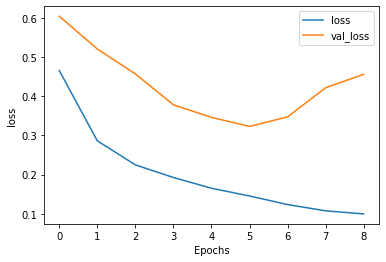

In [412]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [379]:
from sklearn.metrics import classification_report, confusion_matrix

In [400]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = [(1 if y >= 0.5 else 0) for y in y_pred]
y_pred = np.array(y_pred)

138/138 [==============================] - 5s 34ms/step


In [401]:
y_true

array([1, 0, 1, ..., 1, 1, 1])

In [402]:
y_pred

array([1, 0, 1, ..., 1, 0, 1])

In [405]:
print(classification_report(y_true, y_pred, target_names=['Negative Reviews','Positive Reviews']))

                  precision    recall  f1-score   support

Negative Reviews       0.76      0.82      0.79      1364
Positive Reviews       0.92      0.88      0.90      3023

        accuracy                           0.86      4387
       macro avg       0.84      0.85      0.84      4387
    weighted avg       0.87      0.86      0.86      4387



In [406]:
cm = confusion_matrix(y_test, y_pred)

In [407]:
cm

array([[1118,  246],
       [ 354, 2669]])

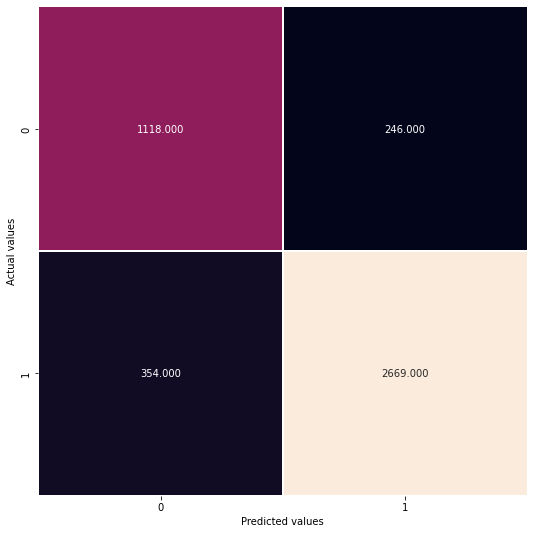

In [413]:
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='0.3f', linewidth=0.5, square=True, cbar=False)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [203]:
def prediction(sentence):
  data = tokenizer.texts_to_sequences([sentence])
  data_pad_sequence = pad_sequences(data, maxlen=50)
  perdiction = model.predict(data_pad_sequence)
  print(perdiction[0])
  if perdiction[0][0] > 0.5:
    return "positive"
  else: 
    return "negative" 